# Training Bidirectional LSTM With Attention

In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import train_test_split
import re
import os

#### Import cleaned data

In [2]:
df = pd.read_csv("/content/cleaned.csv")

In [3]:
df.tail()

,English,Marathi,en_word_count,mar_word_count,mar_char_count,en_char_count
46990,just saying you do not like fish because of th...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...,21,13,68,81
46991,tom tried to sell his old vcr instead of throw...,टॉमने त्याचा जुना व्हीसीआर फेकून टाकण्याऐवजी व...,25,23,129,89
46992,january february march april may june july aug...,जानेवारी फेब्रुवारी मार्च एप्रिल मे जून जुलै ऑ...,20,18,97,104
46993,you cannot view flash content on an ipad howev...,आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या...,32,24,118,140
46994,in roger miller recorded a song called you do...,मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावा...,36,35,149,140


**Note-** this dataset was cleaned in notebook1 [here](https://github.com/AdiShirsath/Neural-Machine-Translation/blob/master/EDA_And_Cleaning_Text.ipynb)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46995 entries, 0 to 46994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   English         46995 non-null  object
 1   Marathi         46995 non-null  object
 2   en_word_count   46995 non-null  int64 
 3   mar_word_count  46995 non-null  int64 
 4   mar_char_count  46995 non-null  int64 
 5   en_char_count   46995 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.2+ MB


### Add start and end tokens to target sentecnes
* This helps model understand when sentence is started and ended
* Beause of this decoder can handle diff length sentence than encoder

In [5]:
df['Marathi'] =df.Marathi.apply(lambda x: 'sos '+ x + ' eos')

In [6]:
df.head()

,English,Marathi,en_word_count,mar_word_count,mar_char_count,en_char_count
0,go,sos जा eos,1,1,2,2
1,run,sos पळ eos,1,1,2,3
2,run,sos धाव eos,1,1,3,3
3,run,sos पळा eos,1,1,3,3
4,run,sos धावा eos,1,1,4,3


##### Convert to list for tokenizer

In [7]:

eng_texts = df.English.to_list()
mar_texts = df.Marathi.to_list()

## Tokenizer
* Converting into numbers

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
def tokenize_sent(text):
  '''
  Take list on texts as input and
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)



In [10]:
# Tokenize english and marathi sentences
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
mar_tokenizer, mar_encoded= tokenize_sent(text= mar_texts)

#### English

In [11]:
eng_encoded[100:105]

[[80, 51], [80, 51], [1, 2705], [1, 26, 3], [1, 26, 3]]

In [12]:
eng_index_word = eng_tokenizer.index_word
eng_word_indec= eng_tokenizer.word_index


### Get vocab size which will be needed next

In [13]:
ENG_VOCAB_SIZE = len(eng_tokenizer.word_counts)+1
ENG_VOCAB_SIZE

5788

#### Mrathi

In [14]:
mar_encoded[30000:30005]

[[1, 35, 576, 645, 4070, 346, 2],
 [1, 414, 167, 93, 707, 1020, 2],
 [1, 1392, 309, 2546, 5, 2],
 [1, 23, 167, 2926, 12, 5, 2],
 [1, 19, 1609, 971, 3, 5, 2]]

In [15]:
mar_index_word = mar_tokenizer.index_word
mar_word_index= mar_tokenizer.word_index


In [16]:
MAR_VOCAB_SIZE=len(mar_tokenizer.word_counts)+1
MAR_VOCAB_SIZE

14390

In [17]:
max_eng_len = 0
for i in range(len(eng_encoded)):
  if len(eng_encoded[i]) > max_eng_len:
    max_eng_len= len(eng_encoded[i])

max_mar_len = 0
for i in range(len(mar_encoded)):
  if len(eng_encoded[i]) > max_mar_len:
    max_mar_len= len(mar_encoded[i])


In [18]:
print(max_eng_len)
max_mar_len

36


37

## Padding
* Making input sentences as max length of input sentence with padding zero
* Same for target make them as max length of target sentence.

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
mar_padded = pad_sequences(mar_encoded, maxlen=max_mar_len, padding='post')


In [21]:
eng_padded

array([[  39,    0,    0, ...,    0,    0,    0],
       [ 408,    0,    0, ...,    0,    0,    0],
       [ 408,    0,    0, ...,    0,    0,    0],
       ...,
       [2093, 2633, 1984, ...,    0,    0,    0],
       [   2,   60, 2593, ...,    0,    0,    0],
       [  10, 4059, 4060, ...,   12,  404,  679]], dtype=int32)

In [22]:
mar_padded.shape

(46995, 37)

##### Converting to array

In [23]:
eng_padded= np.array(eng_padded)
mar_padded= np.array(mar_padded)

## Train test split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(eng_padded, mar_padded, test_size=0.2, random_state=0)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37596, 36), (9399, 36), (37596, 37), (9399, 37))

## Building Model

In [27]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [30]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [31]:
from tensorflow.keras import backend as K

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Concatenate, Dense, Layer
from tensorflow.keras.models import Model
import numpy as np

# Assuming you have your data and vocabulary sizes defined
max_eng_len = 36      # Define your maximum English sequence length
max_mar_len = 37      # Define your maximum Marathi sequence length
ENG_VOCAB_SIZE = 5788    # Define your English vocabulary size
MAR_VOCAB_SIZE = 14390    # Define your Marathi vocabulary size

# Encoder
encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(ENG_VOCAB_SIZE, 1024)(encoder_inputs)
enc_lstm1 = Bidirectional(LSTM(256, return_sequences=True, return_state=True))
encoder_outputs1, forward_h, forward_c, backward_h, backward_c = enc_lstm1(enc_emb)
final_enc_h = Concatenate()([forward_h, backward_h])
final_enc_c = Concatenate()([forward_c, backward_c])
encoder_states = [final_enc_h, final_enc_c]

# Set up the decoder
decoder_inputs = Input(shape=(max_mar_len,))
dec_emb_layer = Embedding(MAR_VOCAB_SIZE, 1024)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Attention Layer
class AttentionLayer(Layer):

    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer
decoder_dense = Dense(MAR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



In [34]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 36, 1024)     5926912     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, 36, 512),   2623488     ['embedding_2[0][0]']            
 )                               (None, 256),                                               

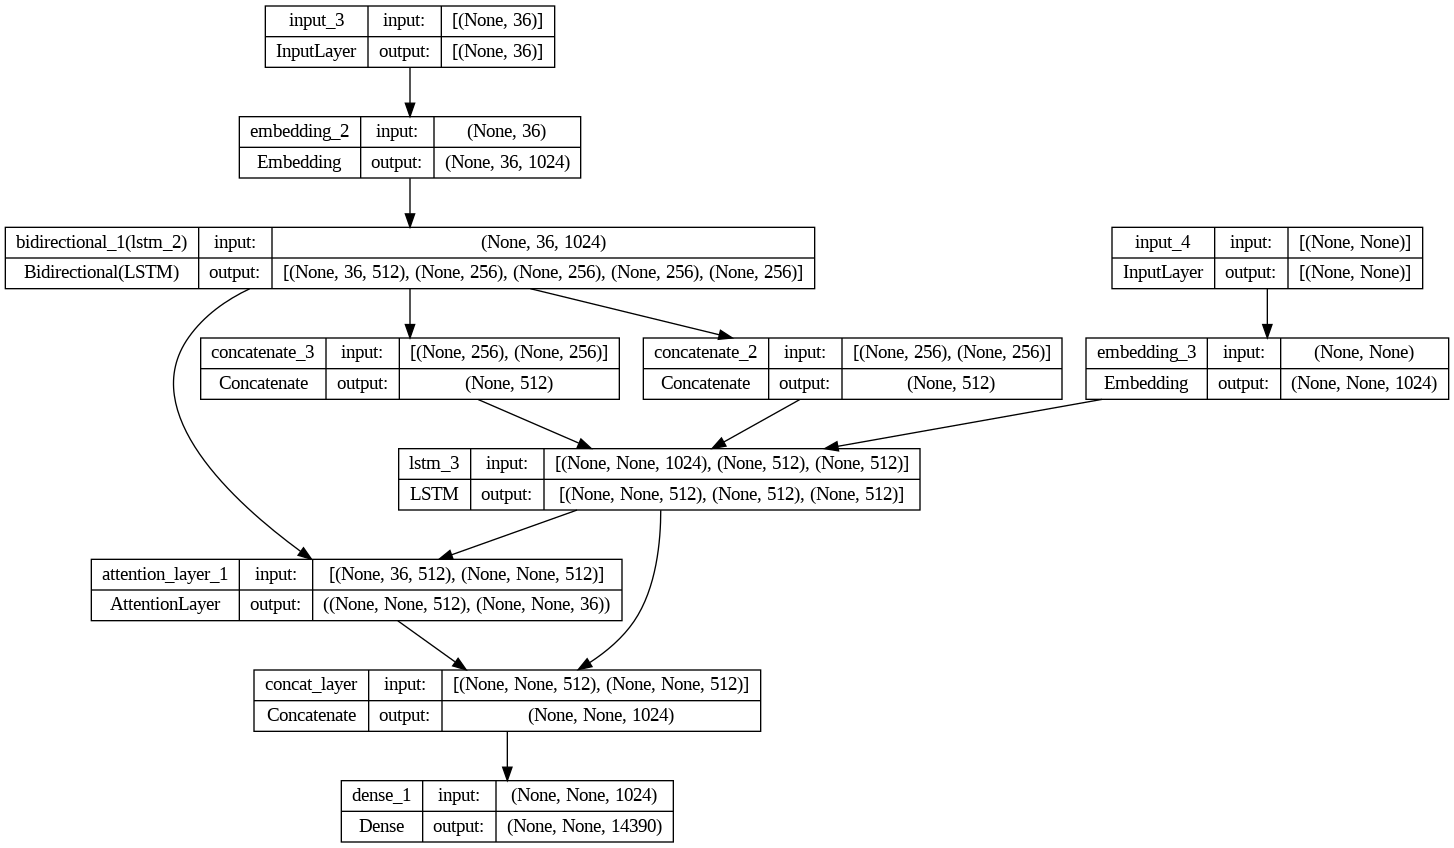

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

***IMP note :- if loss categorical crossentropy used then shapes incompatible error will occcur beause we have to use sparse_categorical_crossentropy when we have all different labels categorical is for mutliclass labels***

In [36]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Define callbacks

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/model_checkpoints/model1/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [38]:
# Training
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

In [39]:
EPOCHS= 30 #@param {type:'slider',min:10,max:100, step:10 }

In [40]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

Epoch 1/50
294/294 [==============================] - ETA: 0s - loss: 1.0680 - accuracy: 0.8680

294/294 [==============================] - 147s 460ms/step - loss: 1.0680 - accuracy: 0.8680 - val_loss: 0.8351 - val_accuracy: 0.8815
Epoch 2/50
294/294 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.8888

294/294 [==============================] - 132s 448ms/step - loss: 0.7468 - accuracy: 0.8888 - val_loss: 0.6825 - val_accuracy: 0.8967
Epoch 3/50
294/294 [==============================] - ETA: 0s - loss: 0.5754 - accuracy: 0.9061

294/294 [==============================] - 131s 447ms/step - loss: 0.5754 - accuracy: 0.9061 - val_loss: 0.5448 - val_accuracy: 0.9129
Epoch 4/50
294/294 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.9241

294/294 [==============================] - 130s 444ms/step - loss: 0.4152 - accuracy: 0.9241 - val_loss: 0.4410 - val_accuracy: 0.9263
Epoch 5/50
294/294 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.9411

294/294 [==============================] - 131s 447ms/step - loss: 0.2842 - accuracy: 0.9411 - val_loss: 0.3728 - val_accuracy: 0.9365
Epoch 6/50
294/294 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9549

294/294 [==============================] - 130s 443ms/step - loss: 0.1920 - accuracy: 0.9549 - val_loss: 0.3376 - val_accuracy: 0.9427
Epoch 7/50
294/294 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9656

294/294 [==============================] - 131s 444ms/step - loss: 0.1340 - accuracy: 0.9656 - val_loss: 0.3225 - val_accuracy: 0.9463
Epoch 8/50
294/294 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9729

294/294 [==============================] - 130s 443ms/step - loss: 0.0992 - accuracy: 0.9729 - val_loss: 0.3139 - val_accuracy: 0.9484
Epoch 9/50
294/294 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9775

294/294 [==============================] - 131s 446ms/step - loss: 0.0781 - accuracy: 0.9775 - val_loss: 0.3106 - val_accuracy: 0.9491
Epoch 10/50
294/294 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9804

294/294 [==============================] - 130s 442ms/step - loss: 0.0651 - accuracy: 0.9804 - val_loss: 0.3104 - val_accuracy: 0.9503
Epoch 11/50
294/294 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9823

294/294 [==============================] - 131s 445ms/step - loss: 0.0563 - accuracy: 0.9823 - val_loss: 0.3095 - val_accuracy: 0.9502
Epoch 12/50
294/294 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9838

294/294 [==============================] - 131s 444ms/step - loss: 0.0497 - accuracy: 0.9838 - val_loss: 0.3140 - val_accuracy: 0.9504
Epoch 13/50
294/294 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9848

294/294 [==============================] - 131s 446ms/step - loss: 0.0455 - accuracy: 0.9848 - val_loss: 0.3135 - val_accuracy: 0.9507
Epoch 14/50
294/294 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9855

294/294 [==============================] - 131s 446ms/step - loss: 0.0424 - accuracy: 0.9855 - val_loss: 0.3172 - val_accuracy: 0.9503
Epoch 15/50
294/294 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9860

294/294 [==============================] - 131s 445ms/step - loss: 0.0403 - accuracy: 0.9860 - val_loss: 0.3181 - val_accuracy: 0.9509
Epoch 16/50
294/294 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9863

294/294 [==============================] - 131s 444ms/step - loss: 0.0387 - accuracy: 0.9863 - val_loss: 0.3181 - val_accuracy: 0.9513
Epoch 17/50
294/294 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9866

294/294 [==============================] - 131s 447ms/step - loss: 0.0374 - accuracy: 0.9866 - val_loss: 0.3207 - val_accuracy: 0.9510
Epoch 18/50
294/294 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9868

294/294 [==============================] - 129s 440ms/step - loss: 0.0363 - accuracy: 0.9868 - val_loss: 0.3218 - val_accuracy: 0.9503
Epoch 19/50
294/294 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9871

294/294 [==============================] - 130s 443ms/step - loss: 0.0350 - accuracy: 0.9871 - val_loss: 0.3241 - val_accuracy: 0.9508
Epoch 20/50
294/294 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9872

294/294 [==============================] - 131s 446ms/step - loss: 0.0345 - accuracy: 0.9872 - val_loss: 0.3247 - val_accuracy: 0.9510
Epoch 21/50
294/294 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9873

294/294 [==============================] - 128s 436ms/step - loss: 0.0339 - accuracy: 0.9873 - val_loss: 0.3270 - val_accuracy: 0.9504


#### Saving weights is very important if ypu dont after colab session ends you might have to retrain model

In [43]:
model.save_weights("/content/Attentionmodel1.h5")

#### After saving weight you can restart colab session without GPU
Create model and
load model

In [44]:
model.load_weights("/content/Attentionmodel1.h5")

## Inference model
* For prediction we have to do this was because we trained encoder on input and decoder on target differently so we'll have to do same for prediction

In [45]:
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

decoder_state_h = Input(shape=(512,))
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(36,512))

dec_states = [decoder_state_h, decoder_state_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])

decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

### Model will predict numbers and word at time so we'll have to convert them to words of language

In [46]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
            # convert max index number to marathi word
            sampled_char = mar_index_word[sampled_token_index]

        if (sampled_char!='end'):
            # aapend it ti decoded sent
            decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= 36):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

## Converting x and y back to words-sentences

In [47]:
def get_marathi_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +mar_index_word[i]+' '
    return sentence

def get_english_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +eng_index_word[i]+' '
    return sentence

# Model results

In [48]:
len(X_test)

9399

#### Using simple loop we will take random 15 numbers from x_test and get results


In [49]:
for i in np.random.randint(10, 1000, size=15):
  print("English Sentence:",get_english_sentence(X_test[i]))
  print("Actual Marathi Sentence:",get_marathi_sentence(y_test[i])[4:-4])
  # Before passing input it has to be reshape as following
  print("Predicted Marathi Translation:",get_predicted_sentence(X_test[i].reshape(1,36))[:-4])
  print("----------------------------------------------------------------------------------------")

English Sentence: tom knows him 
Actual Marathi Sentence: टॉम त्याला ओळखतो 
1/1 [==============================] - 0s 20ms/step
Predicted Marathi Translation:  टॉमला तो माहीत आहे
----------------------------------------------------------------------------------------
English Sentence: we both know why i am here 
Actual Marathi Sentence: मी इथे का आले आहे हे आपल्या दोघांना माहीत आहे 
1/1 [==============================] - 0s 21ms/step
Predicted Marathi Translation:  इथे का हे आम्हा माहीत आहे मला माहीत आहे
----------------------------------------------------------------------------------------
English Sentence: who do you stay with 
Actual Marathi Sentence: कोणाबरोबर राहतेस 
1/1 [==============================] - 0s 21ms/step
Predicted Marathi Translation:  तू कोणाबरोबर राहतेस
----------------------------------------------------------------------------------------
English Sentence: i only found it an hour ago 
Actual Marathi Sentence: त्याला एक तासापूर्वीच सापडलं 
1/1 [==================